In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer

import warnings
warnings.filterwarnings('ignore')

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul>

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [2]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
X = mnist["data"][0:15000] # Subset of 15000 
# X = mnist["data"]
print(X.shape)

(15000, 784)


## Cluster

Initial thoughts:
- Since I am manually assigning the clusters their labels, the number of clusters I choose will not be large. Probably around 30 clusters maximum so that if i need to assign cluster labels multiple times, it won't take too long.
- This could have some drawbacks. More clusters could allow each cluster to be smaller and more specific, taking into account more variations of each digit while also potentially allowing separation of different digits that are similar on many dimensions.
- ex: 1s that look like 7s, squished 8 vs snowman 8s, 2 with loops vs no loops, etc

To get a feel for the clusters, let's do some clustering with KMeans first. We can use tSNE to visualize them in two dimensions after using PCA first to get reduce the 784 dimensions to 50. PCA first will cut down on the amount of time it takes to run tSNE.

In [4]:
# Start with approximately 1 cluster per digit
# 10 clusters 
kmeans = KMeans(10, random_state=97)
labels_kmeans = kmeans.fit_predict(X)

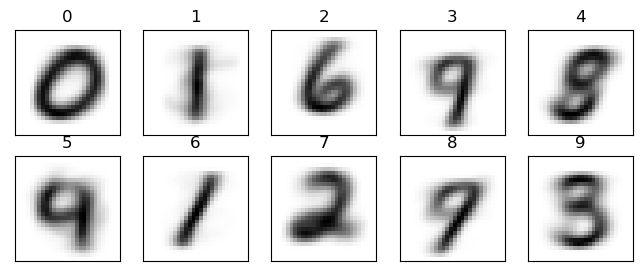

In [5]:
# What does the average digit look like in a cluster?

# Average of cluster arranged as 28*28 image
centers = kmeans.cluster_centers_.reshape(10, 28, 28)

# Plot each average
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8,3))
for label, (axi, center) in enumerate(zip(ax.flat, centers)):
    axi.set(xticks=[], yticks=[], title=label)
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Some possible problems: 
- 7 and 9 grouped together
- 3, 5 and maybe 8 being grouped together in some clusters
- 1 and 5 grouped together
- 4 and 9 grouped together

There could be other poorly clustered numbers that aren't shown through the means

In [6]:
# PCA to 50 before tSNE
pca = PCA(50, whiten=True, random_state=97)
X_pca = pca.fit_transform(X)

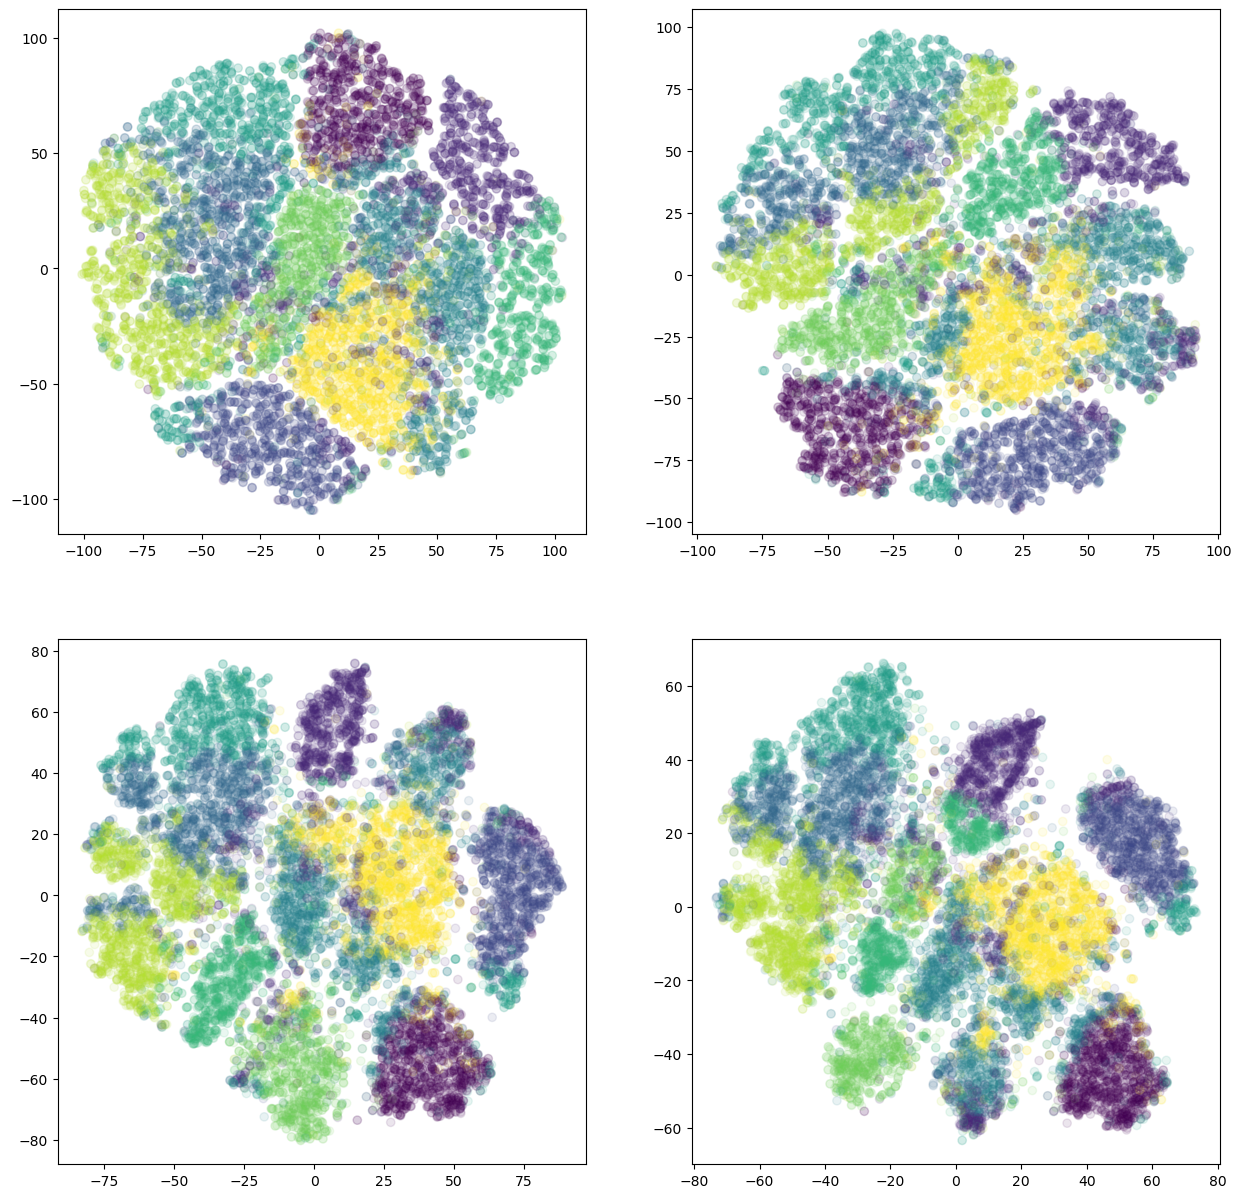

In [7]:
# Visualize using tSNE and multiple perplexities
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
row = 0
col = 0
perp = [5, 10, 25, 50]
for p in perp:
    tSNE = TSNE(n_components=2, init='random', perplexity=p, random_state=97, n_jobs=-1).fit_transform(X_pca)
    ax[row][col].scatter(tSNE[:, 0], tSNE[:, 1], c=labels_kmeans, alpha=.1)
    col += 1
    if col >= 2:
        col = 0
        row += 1
plt.show()

What did I learn from visualizing using tSNE and K-Means
- tSNE uses probabilities to determine which points to keep close together when reducing dimensionality
- Clusters that appear close in the visualization may not accurately represent a group that contains only 1 digit. Some representations of different digits are very similar in many dimensions. Using PCA and tSNE could potentially decrease a model's ability to detect subtle differences that could cluster the digits differently.
- It can produce significantly different results every time
- Using the K-Means labels to color in the tSNE results, the tSNE results may do decent job at keeping the same digits close.

Let's try a clustering algorithm on tSNE results to try and capture the clusters preserved in the dimensionality reduction. The perplexity of 25 appears separate clusters decently. Let's use a Gaussian Mixture Model with covariance_type='full' and more clusters to try and capture weird cluster shapes.

In [8]:
# tSNE using perplexity of 25
tSNE = TSNE(n_components=2, init='random', perplexity=25, random_state=97, n_jobs=-1)
X_tSNE = tSNE.fit_transform(X_pca)

In [9]:
# Initialize and Fit Gaussian Mixture Model to tSNE'd data
gmm25 = GaussianMixture(25, covariance_type='full', random_state=97)
gmm25.fit(X_tSNE)
print(gmm25.converged_)

True


In [10]:
# Labels from Gaussian Mixture
labels_gmm25 = gmm25.predict(X_tSNE)

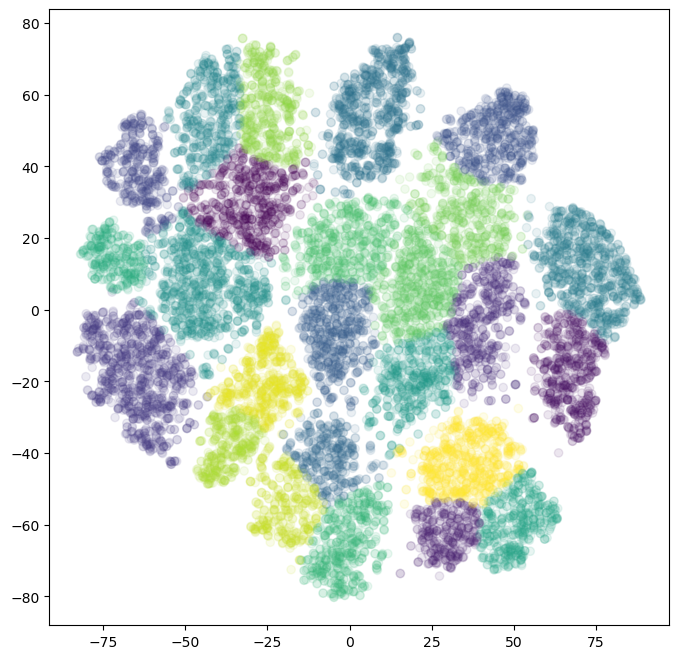

In [11]:
# View plot of clusters on tSNE'd data
plt.figure(figsize=(8,8))
plt.scatter(X_tSNE[:, 0], X_tSNE[:, 1], c=labels_gmm25, alpha=0.1)

In [12]:
# Create a function to visualize the average of each cluster
def visualAverage(pixels, labels, rows, columns):
    df = pixels.copy() # make a copy to avoid changing original dataframe
    df['label'] = labels # add a column for cluster labels
    group_mean = df.groupby('label').mean() # Mean for each pixel in a cluster
    # plot each average digit
    fig, ax = plt.subplots(rows, columns, figsize=(1.5 * columns, 1.5 * rows))
    for label, axi in zip(group_mean.index, ax.flat):
        image = np.array(group_mean.loc[label]).reshape(28, 28) # change to 28*28 image
        axi.set(xticks=[], yticks=[], title=str(label))
        axi.imshow(image, interpolation='nearest', cmap=plt.cm.binary)
    plt.tight_layout()
    plt.show()

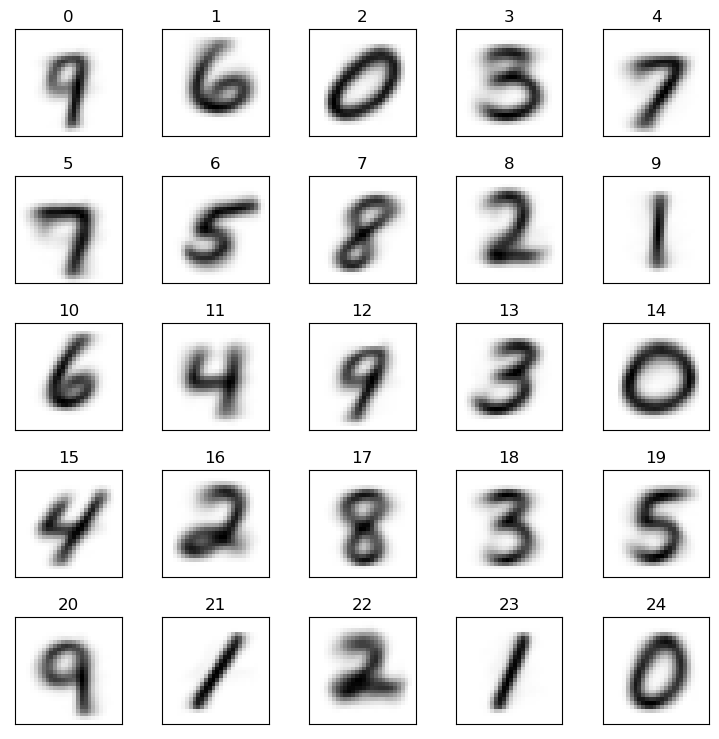

In [13]:
visualAverage(X, labels_gmm25, 5, 5)

Still appears to have trouble with:
- 7s and 9s
- 3s and 5s

Maybe more clusters could eventually separate them out but it would become increasingly time-consuming to relabel all the clusters. A neural network may do a better job at recognizing shapes specific to a digit. For now, the average looks relatively decent and I will accept misclassified samples as an inevitable result of the methods I have chosen.

In [14]:
# Reassign the cluster label to represent the prominent digit in the cluster
labels_gmm25_corrected = pd.DataFrame(labels_gmm25).replace(range(25), (
    9, 6, 0, 3, 7,
    7, 5, 8, 2, 1,
    6, 4, 9, 3, 0,
    4, 2, 8, 3, 5,
    9, 1, 2, 1, 0,
    ))

In [15]:
# Make a copy of the original pixel data for each image
# Add a column with the number labels
results = X.copy()
results['label'] = labels_gmm25_corrected

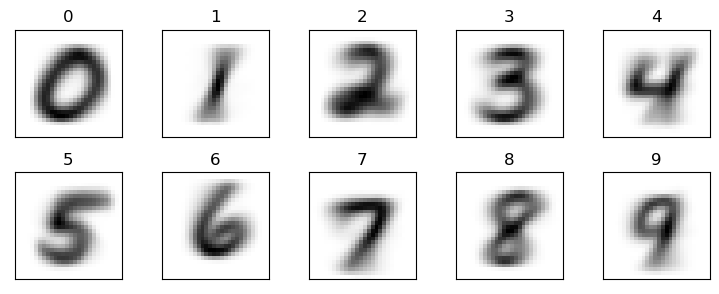

In [16]:
# Ensure the labels and clusters look decent
visualAverage(X, labels_gmm25_corrected, 2, 5)

## Generate Numbers

Clusters contain many variations of the same number and probably some representation of different numbers. By using a Gaussian Mixture model with 1 component to produce a new digit from each cluster, it hopefully creates digits with more often reflect the most prominent representations of a number within a cluster. On the contrary, by using a Gaussian Model with more components within each cluster, we can sample from a smaller number of more similar rows, hopefully resulting in a cleaner image of a particular representation of a digit. However, this could also make it more likely to create an image that reflects the wrong number. 

In [17]:
# Create a function that produces a digit from a cluster
def getDigit(df, label_col, num):
    gmm_digit = GaussianMixture(10, covariance_type='full') # 10 components to try and capture 10 general variations of a digit
    gmm_digit.fit(df[df[label_col] == num].drop(columns=label_col)) # fit the mixture model to all the samples in a cluster
    df_digit = pd.DataFrame(gmm_digit.sample(1)[0]) # dataframe containing the generated image data
    df_digit[df_digit < 75] = 0 # Whiten light colors to increase contrast
    df_digit[df_digit > 125] = 255 # Darken dark colors to increase contrast
    return np.array(df_digit).reshape(28, 28) # Return 28*28 array of image

In [18]:
# Create a function that accepts a number as an argument and generates a new image of a digit for each digit in the number
def writeNumber(number):
    num_as_String = str(number) 
    num_char = len(num_as_String)
    fig, ax = plt.subplots(1, num_char, figsize=(1.5 * num_char, 1.5))
    for char_pos in range(num_char):
        digit = getDigit(results, 'label', int(num_as_String[char_pos])) # Uses getDigit function from above
        if num_char > 1: # for 2 or more digit numbers
            ax[char_pos].imshow(digit, interpolation='nearest', cmap=plt.cm.binary) # plot digit
            ax[char_pos].axis("off")
        elif num_char == 1: # for one digit numbers
            ax.imshow(digit, interpolation='nearest', cmap=plt.cm.binary) # plot digit
            ax.axis("off")
        else:
            return None
    plt.show()

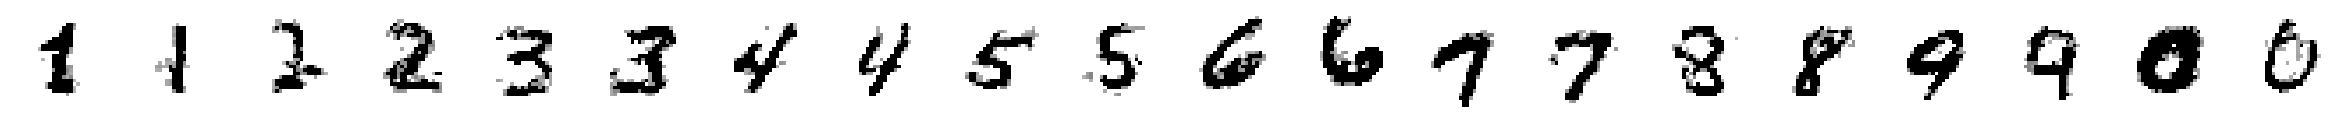

In [19]:
# Test 1
writeNumber(11223344556677889900)

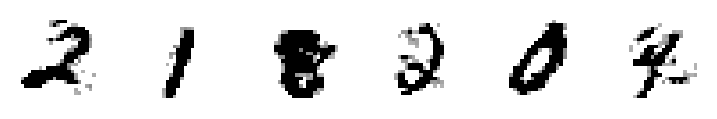

In [20]:
# Test 2
writeNumber(218201)